In [1]:
# sklearn Models
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import linear_model
from sklearn.gaussian_process.kernels import (
    WhiteKernel,
    Matern,
    ConstantKernel,
)

# sklearn Utils
from sklearn.base import BaseEstimator
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import numpy as np
from numpy.random import default_rng
import random

np.random.seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


try:
    from celluloid import Camera
except ModuleNotFoundError:
    %pip install -qq celluloid
    from celluloid import Camera

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils import active_learn_utils as alu

try:
    import modAL
except ModuleNotFoundError:
    %pip install -qq modAL
    import modAL


from modAL.disagreement import max_std_sampling

from modAL.models import ActiveLearner
from modAL.utils.data import modALinput


from typing import Callable
from typing import Tuple
from typing import Optional
import warnings
from typing import List

from IPython.display import HTML
from functools import reduce
import operator

In [2]:
# Default RC parms for grid and line plot
p = plt.rcParams

# Grid Setting
p["grid.color"] = "#999999"
p["grid.linestyle"] = "--"

# Markersize setting for scatter
if pml.is_latexify_enabled():
    p["lines.markersize"] = 3
    p["lines.markeredgewidth"] = 1
    p["lines.linewidth"] = 1.5
    p["grid.linewidth"] = 0.5
else:
    p["lines.markersize"] = 5
    p["lines.markeredgewidth"] = 1.5
    p["lines.linewidth"] = 2

In [3]:
# Choose a model
kernel_0 = ConstantKernel(0.1) * (Matern(length_scale=0.1, nu=2.5)) + WhiteKernel(noise_level_bounds=(1e-10, 1e1))

model_0 = make_pipeline(
    StandardScaler(), GaussianProcessRegressor(kernel=kernel_0, n_restarts_optimizer=10, random_state=0)
)

<a name="Animation_Uncert_MNIST"></a>

### Animation Regression

In [4]:
def reg_line_save(
    i,
    X_train,
    X_pool,
    y_train,
    y_pool,
    X_train_qry,
    y_train_qry,
    X_test_sorted,
    y_pred_sorted,
    rmse,
    std_dev_pts,
    save_name,
):
    fig = plt.figure()
    ax = plt.gca()

    pml.latexify(width_scale_factor=3)

    ax.scatter(
        np.append(X_train, X_pool),
        np.append(y_train, y_pool),
        c="lightgray",
        alpha=0.5,
        label=f"Pool Points",
    )
    ax.scatter(X_train, y_train, c="tab:red", label=f"Train Points", zorder=2)

    if i != 0:
        ax.scatter(
            X_train_qry[-i:],
            y_train_qry[-i:],
            c="limegreen",
            edgecolor="black",
            s=18,
            linewidth=0.75,
            label=f"Queried Points",
            zorder=3,
        )
        # ax.set_title(f"RMSE after {i} queries {rmse:.3f}" )
    else:
        # ax.set_title(f"RMSE for fit on train data {rmse:.3f}" )
        pass

    sns.despine()
    ax.plot(X_test_sorted, y_pred_sorted, c="black", marker="None")
    ax.fill_between(
        X_test_sorted,
        y_pred_sorted - 2 * std_dev_pts,
        y_pred_sorted + 2 * std_dev_pts,
        color="mediumseagreen",
        alpha=0.25,
    )
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.legend(loc="upper left", fontsize=5)
    pml.savefig(save_name)

In [5]:
def animate_regression(sampling_dict_class, grid_row=2, grid_col=2, n_queries=100):

    # Make a plot
    fig, ax = plt.subplots(grid_row, grid_col, figsize=(10, 10))
    camera = Camera(fig)

    # Split data
    X_test, X_train, X_pool, y_test, y_train, y_pool = alu.make_data_reg(initial_train_size=6)

    # Active Learning Loop
    for uncert_key, uncert_val in sampling_dict_class.items():
        (
            uncert_val["queries_np_X"],
            uncert_val["queries_np_y"],
            uncert_val["score"],
            uncert_val["X_pool"],
            uncert_val["y_pool"],
            uncert_val["st_dev_pts"],
        ) = alu.process_uncertainty_result(
            uncert_val["model"],
            uncert_val["query_strat"],
            "Regression",
            uncert_key,
            n_queries=n_queries,
            X_pool=X_pool,
            y_pool=y_pool,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
        )

    # Loop over each iteration of the each query startergy
    for i in range(n_queries + 1):

        X_reg_line = None
        y_reg_line = None

        for col, (key, value) in enumerate(sampling_dict_class.items()):

            # Setup data for training
            if i == 0:
                X_train_qry = X_train
                y_train_qry = y_train
            else:
                X_train_qry = np.append(X_train, value["queries_np_X"][:i])
                y_train_qry = np.append(y_train, value["queries_np_y"][:i])

            X_pool_final = np.array(value["X_pool"])
            y_pool_final = np.array(value["y_pool"])

            # Model fit
            model_qry = clone(uncert_val["model"]).fit(X_train_qry.reshape(-1, 1), y_train_qry)

            # Make Predictions
            y_pred = model_qry.predict(X_test)

            # Sort X_test to plot the curve
            X_test_argsort = np.argsort(X_test.squeeze())
            X_test_sorted = X_test[X_test_argsort].squeeze()

            # Sort the predictions as well
            y_pred_sorted = y_pred[X_test_argsort].squeeze()

            # Sort std devs
            y_test_stddev_pts = value["st_dev_pts"][i][X_test_argsort]

            # Make 2 plots for each query stratergy
            for row, graph_type in enumerate(["reg_line", "accuracy_line"]):

                if graph_type == "reg_line":

                    ax[row][col].scatter(X_pool, y_pool, c="gray", alpha=0.5, label=f"Pool Points")

                    ax[row][col].scatter(X_train, y_train, c="red", label=f"Train Points")

                    if i != 0:
                        ax[row][col].scatter(
                            X_train_qry[-i:],
                            y_train_qry[-i:],
                            c="limegreen",
                            edgecolor="black",
                            label=f"Queried Points",
                        )
                        ax[row][col].scatter(
                            X_train_qry[-1],
                            y_train_qry[-1],
                            c="limegreen",
                            edgecolor="black",
                            s=50,
                            zorder=3,
                            label=f"Queried Points+{i}",
                        )

                    ax[row][col].plot(X_test_sorted, y_pred_sorted, c="black", marker="None")
                    ax[row][col].fill_between(
                        X_test_sorted,
                        y_pred_sorted - 2 * y_test_stddev_pts,
                        y_pred_sorted + 2 * y_test_stddev_pts,
                        color="mediumseagreen",
                        alpha=0.25,
                    )
                    ax[row][col].set_xlabel("X")
                    ax[row][col].set_ylabel("y")
                    ax[row][col].set_title(key)

                    if i in [0, 4] and pml.is_latexify_enabled() and value["save_dec"]:
                        print(f"RMSE on iter {i} for query strat {key} is {value['score'][i]}")
                        reg_line_save(
                            i,
                            X_train,
                            X_pool,
                            y_train,
                            y_pool,
                            X_train_qry,
                            y_train_qry,
                            X_test_sorted,
                            y_pred_sorted,
                            value["score"][i],
                            y_test_stddev_pts,
                            f"{value['save_dec']}_reg_iter_{i}",
                        )

                elif graph_type == "accuracy_line":

                    ax[row][col].grid(True)

                    if i == 0:
                        ax[row][col].scatter([i], value["score"][i], color=value["color_scheme"])
                    else:
                        ax[row][col].plot(
                            [itr for itr in range(i + 1)],
                            value["score"][: i + 1],
                            color=value["color_scheme"],
                        )
                        ax[row][col].set_xticks([i for i in range(0, i + 1, 2)])

                    ax[row][col].set_xlabel("Number of Iterations")

                    if col == 0:
                        ax[row][col].set_ylabel("RMSE")

        plt.subplots_adjust(hspace=0.2)

        camera.snap()

    animation = camera.animate(interval=500, blit=True)
    return animation

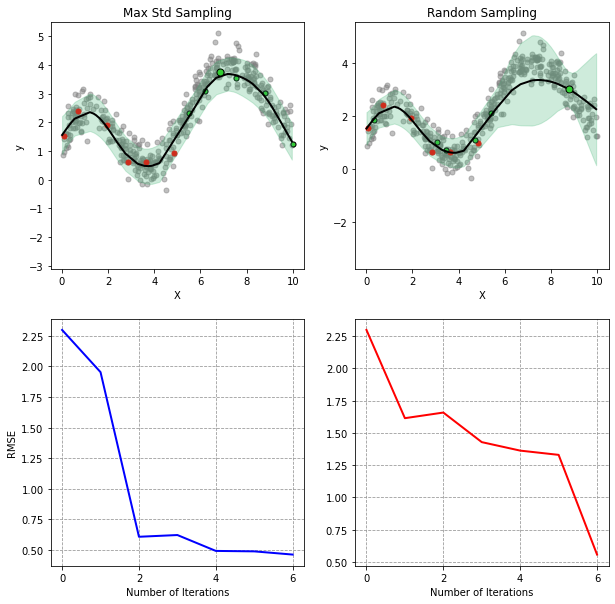

In [6]:
warnings.filterwarnings("ignore")

sampling_dict_reg_animate = {
    "Max Std Sampling": {
        "model": clone(model_0),
        "query_strat": max_std_sampling,
        "score": [],
        "std_dev_pts": [],
        "marker": "o",
        "type": "uncertanity",
        "queries_np_X": None,
        "queries_np_y": None,
        "color_scheme": "blue",
        "save_dec": "Least Confidence Decision",
        "X_pool": None,
        "y_pool": None,
        "save_dec": "Max_Std_Sampling_",
    },
    "Random Sampling": {
        "model": clone(model_0),
        "query_strat": alu.random_sampling,
        "score": [],
        "st_dev_pts": [],
        "marker": "H",
        "type": "random",
        "queries_np_X": None,
        "queries_np_y": None,
        "color_scheme": "red",
        "save_dec": "Random Sampling Decision",
        "X_pool": None,
        "y_pool": None,
        "save_dec": "Random_Sampling_",
    },
}


animation = animate_regression(sampling_dict_reg_animate, 2, 2, n_queries=6)
HTML(animation.to_jshtml())